In [18]:
# Standard library imports
from pathlib import Path

# Third party imports
import geopandas as gpd
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import plotly.express as px

# Local imports
from detect import compute_run_lengths, detect_change, make_change_map, make_outlier_mask


# Constants
DATA_DIR = Path(r"C:\Users\Peter\gh\rasmussen-705.603\data\FinalProject")
# Cleanup / outlier detection params
WINDOW = 10
START_INDEX = 10
N_STDS = 1.75
# Region-level BOCD model params

BOCD_PARAMS = {
    "af-kharkamar-2022": dict(
        alpha=1,
        beta=1,
        hazard=1e10,
        kappa=1.0,
        mu=1,
        ),
    "gm-kanifing-2022": dict(
        alpha=1,
        beta=1,
        hazard=1e10,
        kappa=1.0,
        mu=1,
        ),
    "in-cianjur-2022": dict(
        alpha=1,
        beta=1,
        hazard=1e10,
        kappa=1.0,
        mu=1,
        ),
    "mg-farafangana-2022": dict(
        alpha=1,
        beta=1,
        hazard=1e10,
        kappa=1.0,
        mu=1,
        ),
    "tr-islahiye-2023": dict(
        alpha=1,
        beta=1,
        hazard=1e10,
        kappa=1.0,
        mu=1,
        ),
    "us-baltimore-9999": dict(
        alpha=1,
        beta=1,
        hazard=100,
        kappa=1.0,
        mu=1,
        ),
}

# Define directories
raw_dir = DATA_DIR / "raw"
interim_dir = DATA_DIR / "interim"
processed_dir = DATA_DIR / "processed"
cogs_dir = interim_dir / "cogs"
autoencoder_dir = processed_dir / "autoencoder"
models_dir = interim_dir / "models"
scores_dir = interim_dir / "scores"
encoded_dir = interim_dir / "encoded"
meta_dir = interim_dir / "meta"
change_maps_dir = interim_dir / "change_maps"

change_maps_dir.mkdir(exist_ok=True, parents=True)

cores = multiprocessing.cpu_count()

In [19]:
regions = gpd.read_file(raw_dir / "regions.geojson").set_index("event_key")
for region, region_meta in regions.iterrows():
    change_map_dst = change_maps_dir / f"{region}.csv"
    if change_map_dst.exists():
        print(f"[Detect]: Skip {region}.")    
        continue
    print(f"[Detect]: Processing {region}...")

    # Load region dataset and metadata
    encoded_src = encoded_dir / f"{region}.npy"
    meta_src = meta_dir / f"{region}.csv"
    encoded = np.load(encoded_src)[START_INDEX:, :, :, :]  # chop off first N timesteps
    cogs_meta = pd.read_csv(meta_src).iloc[START_INDEX:, :].reset_index(drop=True)
    
    # Prep inputs
    timesteps, rows, cols, channels = encoded.shape
    cogs_meta["solar_date"] = pd.to_datetime(cogs_meta["solar_date"])
    cogs_meta.reset_index(drop=True, inplace=True)
    
    # Create mask to remove outliers that wreak havoc on change detection algo
    mask = make_outlier_mask(encoded, window=WINDOW, axis=0, n_stds=N_STDS)
    
    # Make change map for each channel / component
    change_map = make_change_map(encoded, cogs_meta, mask, region, BOCD_PARAMS, cores)
    
    # Save outputs
    change_map.to_csv(change_map_dst, index=False)
    
    print(f"[Detect]: Saved change map for {region}.")

[Detect]: Processing af-kharkamar-2022...
[Detect]: Processing gm-kanifing-2022...


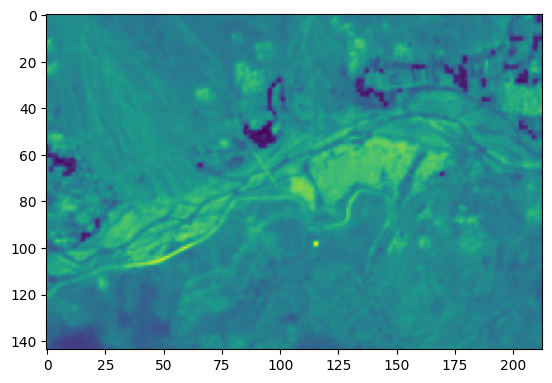

In [157]:
plt.imshow(encoded[0, :, :, 0])

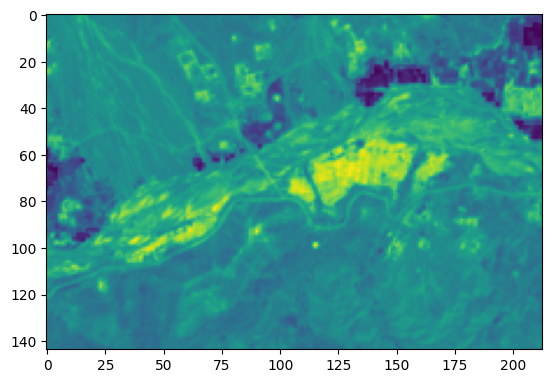

In [158]:
plt.imshow(encoded[-1, :, :, 0])

In [152]:
px.imshow(reshaped_encoded.T.reshape(timesteps, rows, cols)[0])

['2022-05-13']


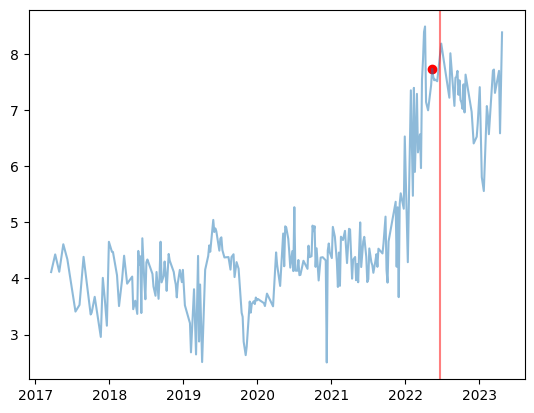

In [279]:


component = 0

arr_mask = mask[:, 58, 125, component]
dates = cogs_meta["solar_date"].values[arr_mask]

arr = encoded[:, 58, 125, component][arr_mask]

run_lengths = compute_run_lengths(arr, BOCD_PARAMS, region)
index_changes = detect_change(run_lengths)
change_dates = retrieve_change_dates(dates, index_changes)

change_summary = pd.Series(change_dates).describe(datetime_is_numeric=True).to_dict()


print([str(x.date()) for x in change_dates])
plt.plot(dates, arr, alpha=0.5, label="observation")
plt.axvline(x = event_date, color = 'r', alpha=0.5, label = 'axvline - full height')
plt.scatter(change_dates, arr[index_changes], c="red", label="change point")

In [300]:

dates = cogs_meta["solar_date"].tolist()

arr = encoded[:, row, col, 1]
run_lengths = compute_run_lengths(arr, BOCD_PARAMS, region)
index_changes = detect_change(run_lengths)
change_dates = retrieve_change_dates(cogs_meta, index_changes)
change_summary = pd.Series(change_dates).describe(datetime_is_numeric=True).to_dict()

ValueError: to assemble mappings requires at least that [year, month, day] be specified: [day,month,year] is missing

In [304]:
component = 0
reshaped_encoded = encoded.copy()[:, :, :, component].reshape(timesteps, rows * cols).T
reshaped_mask = mask.copy()[:, :, :, component].reshape(timesteps, rows * cols).T
unipix = 0
summarize_pixel(reshaped_encoded, unipix, reshaped_mask, BOCD_PARAMS, cogs_meta, region)

{'count': 1,
 'mean': Timestamp('2022-08-06 00:00:00'),
 'min': Timestamp('2022-08-06 00:00:00'),
 '25%': Timestamp('2022-08-06 00:00:00'),
 '50%': Timestamp('2022-08-06 00:00:00'),
 '75%': Timestamp('2022-08-06 00:00:00'),
 'max': Timestamp('2022-08-06 00:00:00')}

In [128]:

# # reshaped_encoded = encoded.copy()[:, :10, :10, 0].reshape(timesteps, 10*10).T
# counter = 0
# change_map = []
# for unipix in range(len(reshaped_encoded)):
#     change_summary = summarize_pixel(reshaped_encoded, unipix, BOCD_PARAMS, region)    
#     # run_lengths = compute_run_lengths(reshaped_encoded[unipix, :], BOCD_PARAMS, region)
#     # index_changes = detect_change(run_lengths)
#     # change_dates = retrieve_change_dates(cogs_meta, index_changes)
#     # change_summary = pd.Series(change_dates).describe(datetime_is_numeric=True).to_dict()
#     change_map.append(change_summary)
#     # counter += 1
#     # if counter > 100:
#     #     break

2022-06-21 00:00:00


<Axes: >

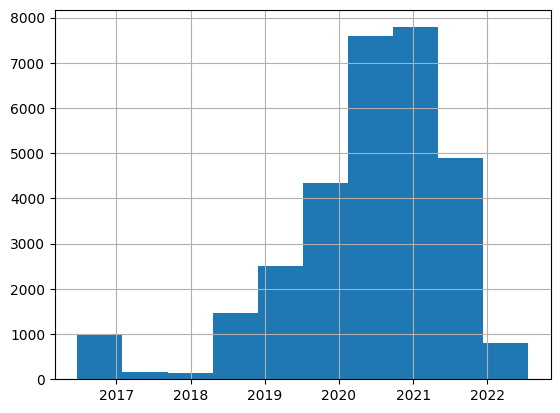

In [139]:
print(event_date)
change_map["50%"].hist()#.describe(datetime_is_numeric=True)

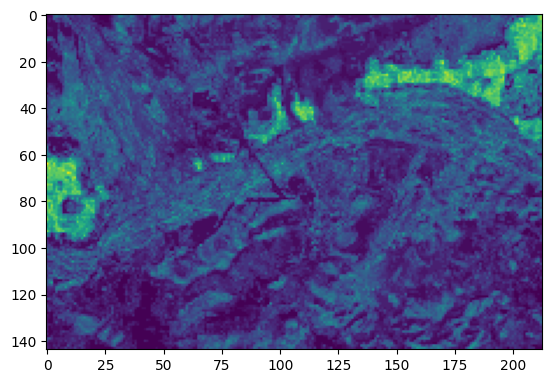

In [131]:
plt.imshow(pd.DataFrame(change_map)["count"].values.reshape(rows, cols))

In [151]:
change_map["count"]

0         3
1         3
2         4
3        11
4        13
         ..
30667     6
30668     6
30669     2
30670     2
30671     2
Name: count, Length: 30672, dtype: int64

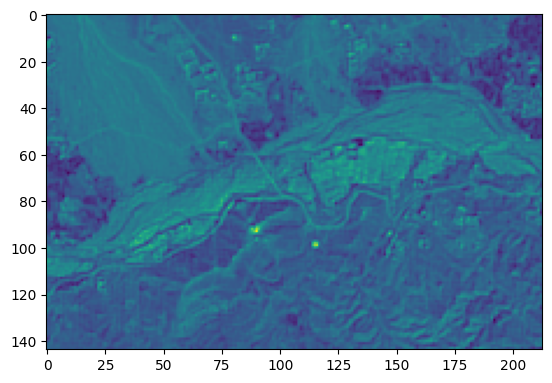

In [148]:
plt.imshow(encoded[-10, :, :, 1])

In [11]:
dataset.cube[:, :, :, -2]

array([[[-0.12877533, -0.12877533, -0.12877533, ..., -0.12877533,
         -0.12877533, -0.12877533],
        [-0.12877533, -0.12877533, -0.12877533, ..., -0.12877533,
         -0.12877533, -0.12877533],
        [-0.12877533, -0.12877533, -0.12877533, ..., -0.12877533,
         -0.12877533, -0.12877533],
        ...,
        [-0.12877533, -0.12877533, -0.12877533, ..., -0.12877533,
         -0.12877533, -0.12877533],
        [-0.12877533, -0.12877533, -0.12877533, ..., -0.12877533,
         -0.12877533, -0.12877533],
        [-0.12877533, -0.12877533, -0.12877533, ..., -0.12877533,
         -0.12877533, -0.12877533]],

       [[-0.12877533, -0.12877533, -0.12877533, ..., -0.12877533,
          7.764047  ,  7.764047  ],
        [-0.12877533, -0.12877533, -0.12877533, ...,  7.764047  ,
          7.764047  ,  7.764047  ],
        [-0.12877533, -0.12877533, -0.12877533, ...,  7.764047  ,
          7.764047  ,  7.764047  ],
        ...,
        [-0.12877533, -0.12877533, -0.12877533, ..., -